In [1]:
#Koneksi ke google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install jcopdl==1.1.10

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=4a558a41df8b70c4f41f274c9658c028c0f0a93b55dc673df108f6814953db12
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


In [3]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Konfigurasi cpu atau gpu

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Dataset & Dataloader

In [7]:
bs = 128
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/archive/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/archive/val/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [8]:
#Membaca Label
label2cat = train_set.classes
label2cat

['bleaching', 'non-bleaching']

Arsitektur Dan Config

In [9]:
import torch.nn as nn
from torchvision.models import mobilenet_v2
mnet = mobilenet_v2(pretrained=True)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 75.2MB/s]


In [10]:
for param in mnet.parameters():
    param.requires_grad = False

In [11]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
# Modify the classifier
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)


In [14]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.LogSoftmax()
    )

  def forward(self, x):
    return self.mnet(x)

  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [16]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
})

Phase 1: Adaptation (learning rate 0.0001)

In [17]:
model = CustomMobileNetv2(config.output_size).to(device)

# Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Assuming you have a 'Callback' class defined somewhere
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [18]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()

  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6447 | Test_cost  = 0.5761 | Train_score = 0.6230 | Test_score = 0.7021 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.5394 | Test_cost  = 0.5098 | Train_score = 0.7378 | Test_score = 0.7508 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.4875 | Test_cost  = 0.4725 | Train_score = 0.7790 | Test_score = 0.7746 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4547 | Test_cost  = 0.4540 | Train_score = 0.7887 | Test_score = 0.7898 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4514 | Test_cost  = 0.4412 | Train_score = 0.7876 | Test_score = 0.7974 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4371 | Test_cost  = 0.4395 | Train_score = 0.7963 | Test_score = 0.8007 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4496 | Test_cost  = 0.4528 | Train_score = 0.7898 | Test_score = 0.7757 |
==> EarlyStop patience =  1 | Best test_score: 0.8007


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4439 | Test_cost  = 0.4218 | Train_score = 0.7941 | Test_score = 0.8158 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4332 | Test_cost  = 0.4291 | Train_score = 0.7931 | Test_score = 0.8028 |
==> EarlyStop patience =  1 | Best test_score: 0.8158


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4080 | Test_cost  = 0.4306 | Train_score = 0.8082 | Test_score = 0.8017 |
==> EarlyStop patience =  2 | Best test_score: 0.8158
==> Execute Early Stopping at epoch: 10 | Best test_score: 0.8158
==> Best model is saved at model


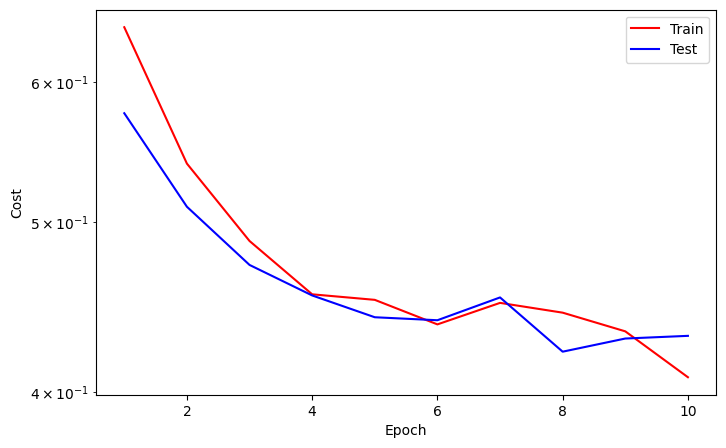

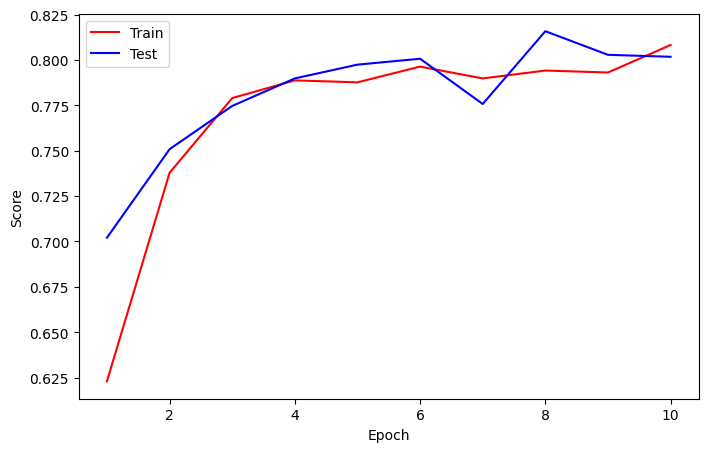

In [20]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

Phase 2 : Fine Tuning (Learning rate dikecilin)

In [21]:
#unfreeze weights
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4157 | Test_cost  = 0.4076 | Train_score = 0.8158 | Test_score = 0.8256 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4039 | Test_cost  = 0.3931 | Train_score = 0.8202 | Test_score = 0.8364 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3918 | Test_cost  = 0.3816 | Train_score = 0.8256 | Test_score = 0.8451 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3650 | Test_cost  = 0.3693 | Train_score = 0.8516 | Test_score = 0.8527 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3635 | Test_cost  = 0.3572 | Train_score = 0.8505 | Test_score = 0.8667 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3458 | Test_cost  = 0.3479 | Train_score = 0.8613 | Test_score = 0.8657 |
==> EarlyStop patience =  1 | Best test_score: 0.8667


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3309 | Test_cost  = 0.3390 | Train_score = 0.8657 | Test_score = 0.8689 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3320 | Test_cost  = 0.3327 | Train_score = 0.8602 | Test_score = 0.8711 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3138 | Test_cost  = 0.3246 | Train_score = 0.8722 | Test_score = 0.8776 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3089 | Test_cost  = 0.3176 | Train_score = 0.8711 | Test_score = 0.8819 |


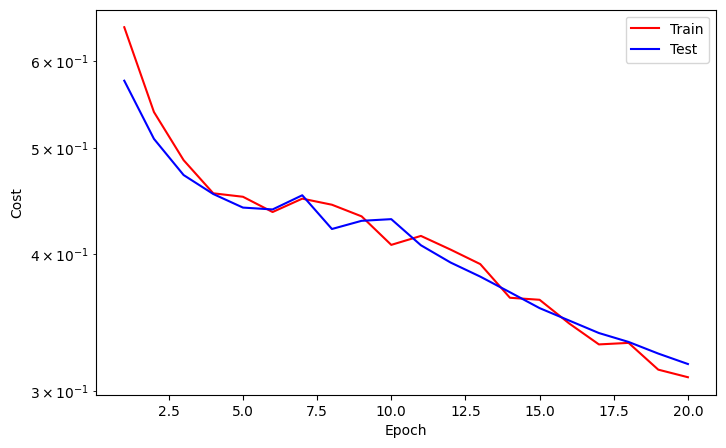

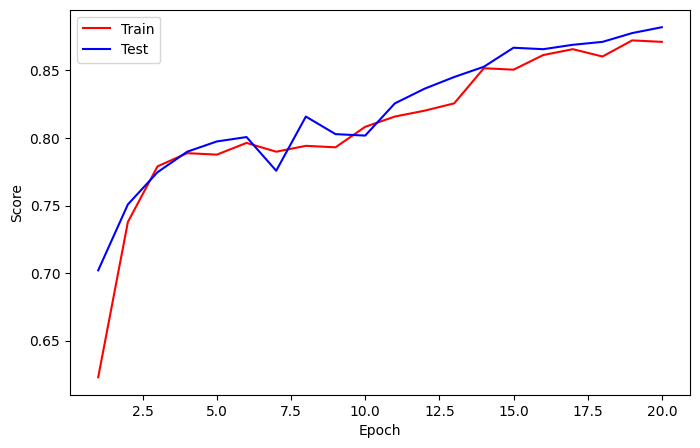

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3015 | Test_cost  = 0.3088 | Train_score = 0.8754 | Test_score = 0.8906 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3043 | Test_cost  = 0.3014 | Train_score = 0.8765 | Test_score = 0.8917 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.2806 | Test_cost  = 0.2926 | Train_score = 0.8938 | Test_score = 0.9014 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.2825 | Test_cost  = 0.2856 | Train_score = 0.8852 | Test_score = 0.8982 |
==> EarlyStop patience =  1 | Best test_score: 0.9014


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.2728 | Test_cost  = 0.2779 | Train_score = 0.8862 | Test_score = 0.8992 |
==> EarlyStop patience =  2 | Best test_score: 0.9014


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.2568 | Test_cost  = 0.2711 | Train_score = 0.8960 | Test_score = 0.9079 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.2541 | Test_cost  = 0.2630 | Train_score = 0.9047 | Test_score = 0.9133 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.2643 | Test_cost  = 0.2572 | Train_score = 0.8949 | Test_score = 0.9090 |
==> EarlyStop patience =  1 | Best test_score: 0.9133


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.2425 | Test_cost  = 0.2530 | Train_score = 0.9068 | Test_score = 0.9090 |
==> EarlyStop patience =  2 | Best test_score: 0.9133


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.2361 | Test_cost  = 0.2476 | Train_score = 0.9144 | Test_score = 0.9112 |
==> EarlyStop patience =  3 | Best test_score: 0.9133


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.2366 | Test_cost  = 0.2397 | Train_score = 0.9122 | Test_score = 0.9209 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.2269 | Test_cost  = 0.2327 | Train_score = 0.9263 | Test_score = 0.9252 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.2264 | Test_cost  = 0.2267 | Train_score = 0.9112 | Test_score = 0.9263 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.2177 | Test_cost  = 0.2202 | Train_score = 0.9177 | Test_score = 0.9307 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.2053 | Test_cost  = 0.2150 | Train_score = 0.9274 | Test_score = 0.9307 |
==> EarlyStop patience =  1 | Best test_score: 0.9307


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.2102 | Test_cost  = 0.2090 | Train_score = 0.9242 | Test_score = 0.9317 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.1976 | Test_cost  = 0.2050 | Train_score = 0.9372 | Test_score = 0.9350 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.1790 | Test_cost  = 0.1993 | Train_score = 0.9437 | Test_score = 0.9361 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.1828 | Test_cost  = 0.1946 | Train_score = 0.9382 | Test_score = 0.9382 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.1779 | Test_cost  = 0.1890 | Train_score = 0.9415 | Test_score = 0.9393 |


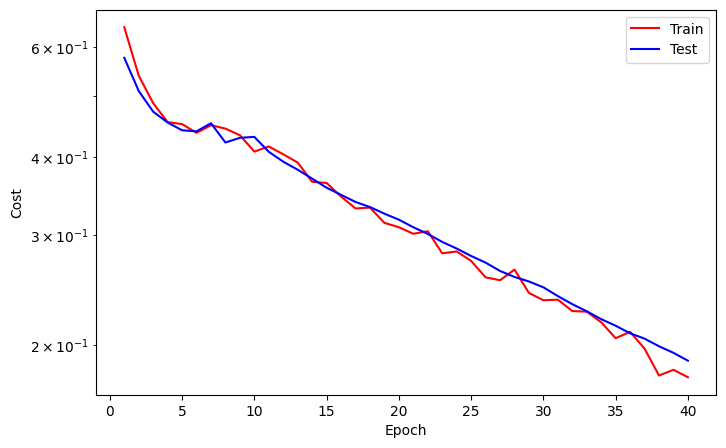

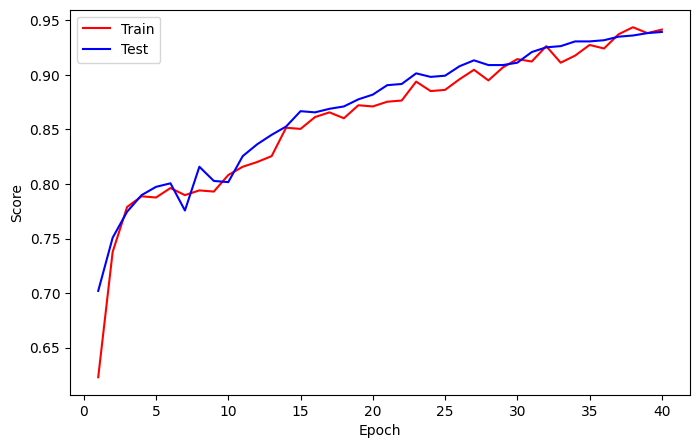

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.1644 | Test_cost  = 0.1835 | Train_score = 0.9567 | Test_score = 0.9426 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.1719 | Test_cost  = 0.1797 | Train_score = 0.9317 | Test_score = 0.9437 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.1620 | Test_cost  = 0.1773 | Train_score = 0.9458 | Test_score = 0.9404 |
==> EarlyStop patience =  1 | Best test_score: 0.9437


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.1621 | Test_cost  = 0.1730 | Train_score = 0.9437 | Test_score = 0.9426 |
==> EarlyStop patience =  2 | Best test_score: 0.9437


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.1641 | Test_cost  = 0.1673 | Train_score = 0.9469 | Test_score = 0.9469 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.1575 | Test_cost  = 0.1612 | Train_score = 0.9567 | Test_score = 0.9512 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.1531 | Test_cost  = 0.1560 | Train_score = 0.9491 | Test_score = 0.9512 |
==> EarlyStop patience =  1 | Best test_score: 0.9512


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.1318 | Test_cost  = 0.1518 | Train_score = 0.9718 | Test_score = 0.9545 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.1411 | Test_cost  = 0.1479 | Train_score = 0.9588 | Test_score = 0.9523 |
==> EarlyStop patience =  1 | Best test_score: 0.9545


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.1426 | Test_cost  = 0.1451 | Train_score = 0.9545 | Test_score = 0.9567 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.1443 | Test_cost  = 0.1448 | Train_score = 0.9577 | Test_score = 0.9545 |
==> EarlyStop patience =  1 | Best test_score: 0.9567


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.1278 | Test_cost  = 0.1366 | Train_score = 0.9599 | Test_score = 0.9621 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.1108 | Test_cost  = 0.1328 | Train_score = 0.9675 | Test_score = 0.9632 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.1195 | Test_cost  = 0.1282 | Train_score = 0.9707 | Test_score = 0.9610 |
==> EarlyStop patience =  1 | Best test_score: 0.9632


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.1274 | Test_cost  = 0.1261 | Train_score = 0.9718 | Test_score = 0.9610 |
==> EarlyStop patience =  2 | Best test_score: 0.9632


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.1095 | Test_cost  = 0.1231 | Train_score = 0.9718 | Test_score = 0.9642 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.1226 | Test_cost  = 0.1213 | Train_score = 0.9567 | Test_score = 0.9653 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.1014 | Test_cost  = 0.1193 | Train_score = 0.9718 | Test_score = 0.9642 |
==> EarlyStop patience =  1 | Best test_score: 0.9653


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.1058 | Test_cost  = 0.1164 | Train_score = 0.9740 | Test_score = 0.9632 |
==> EarlyStop patience =  2 | Best test_score: 0.9653


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.0980 | Test_cost  = 0.1158 | Train_score = 0.9751 | Test_score = 0.9642 |


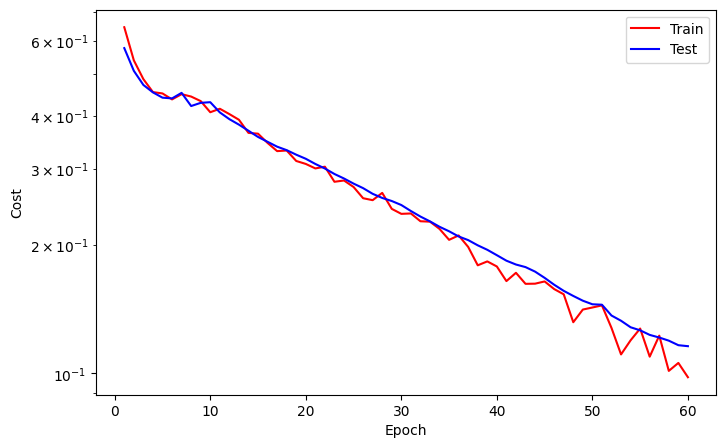

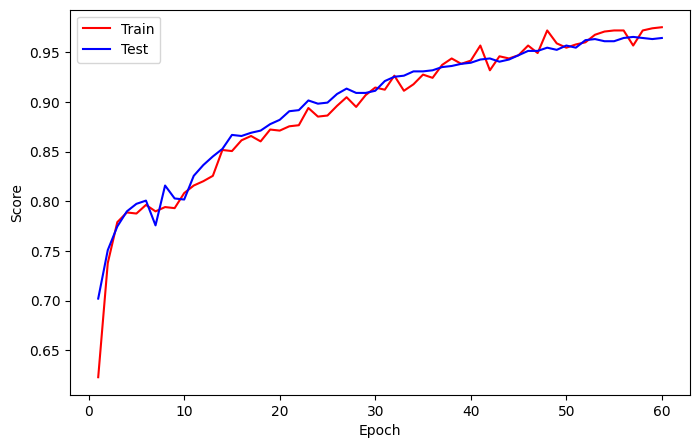

==> EarlyStop patience =  3 | Best test_score: 0.9653


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.0957 | Test_cost  = 0.1097 | Train_score = 0.9729 | Test_score = 0.9653 |
==> EarlyStop patience =  4 | Best test_score: 0.9653


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.1024 | Test_cost  = 0.1086 | Train_score = 0.9718 | Test_score = 0.9642 |
==> EarlyStop patience =  5 | Best test_score: 0.9653
==> Execute Early Stopping at epoch: 62 | Best test_score: 0.9653
==> Best model is saved at model


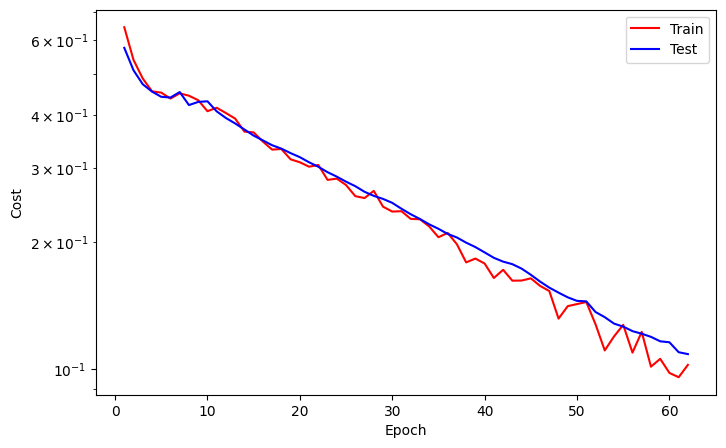

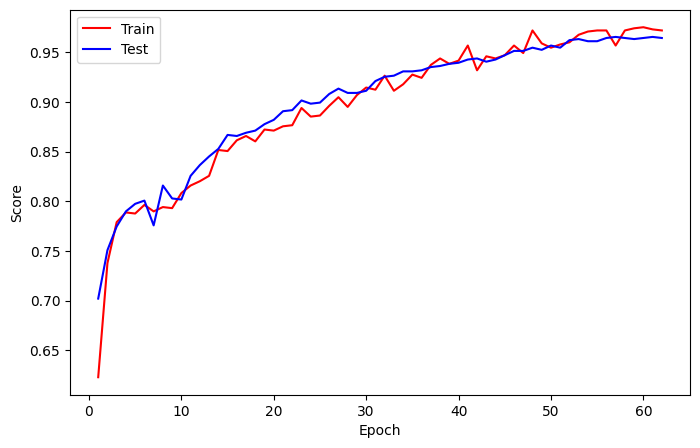

In [22]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

Prediksi

In [23]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [24]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')

In [25]:
#inverse Images
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] = 0.229 + 0.485
    img[1, :, :] = img[1, :, :] = 0.224 + 0.456
    img[2, :, :] = img[2, :, :] = 0.225 + 0.406
    return img

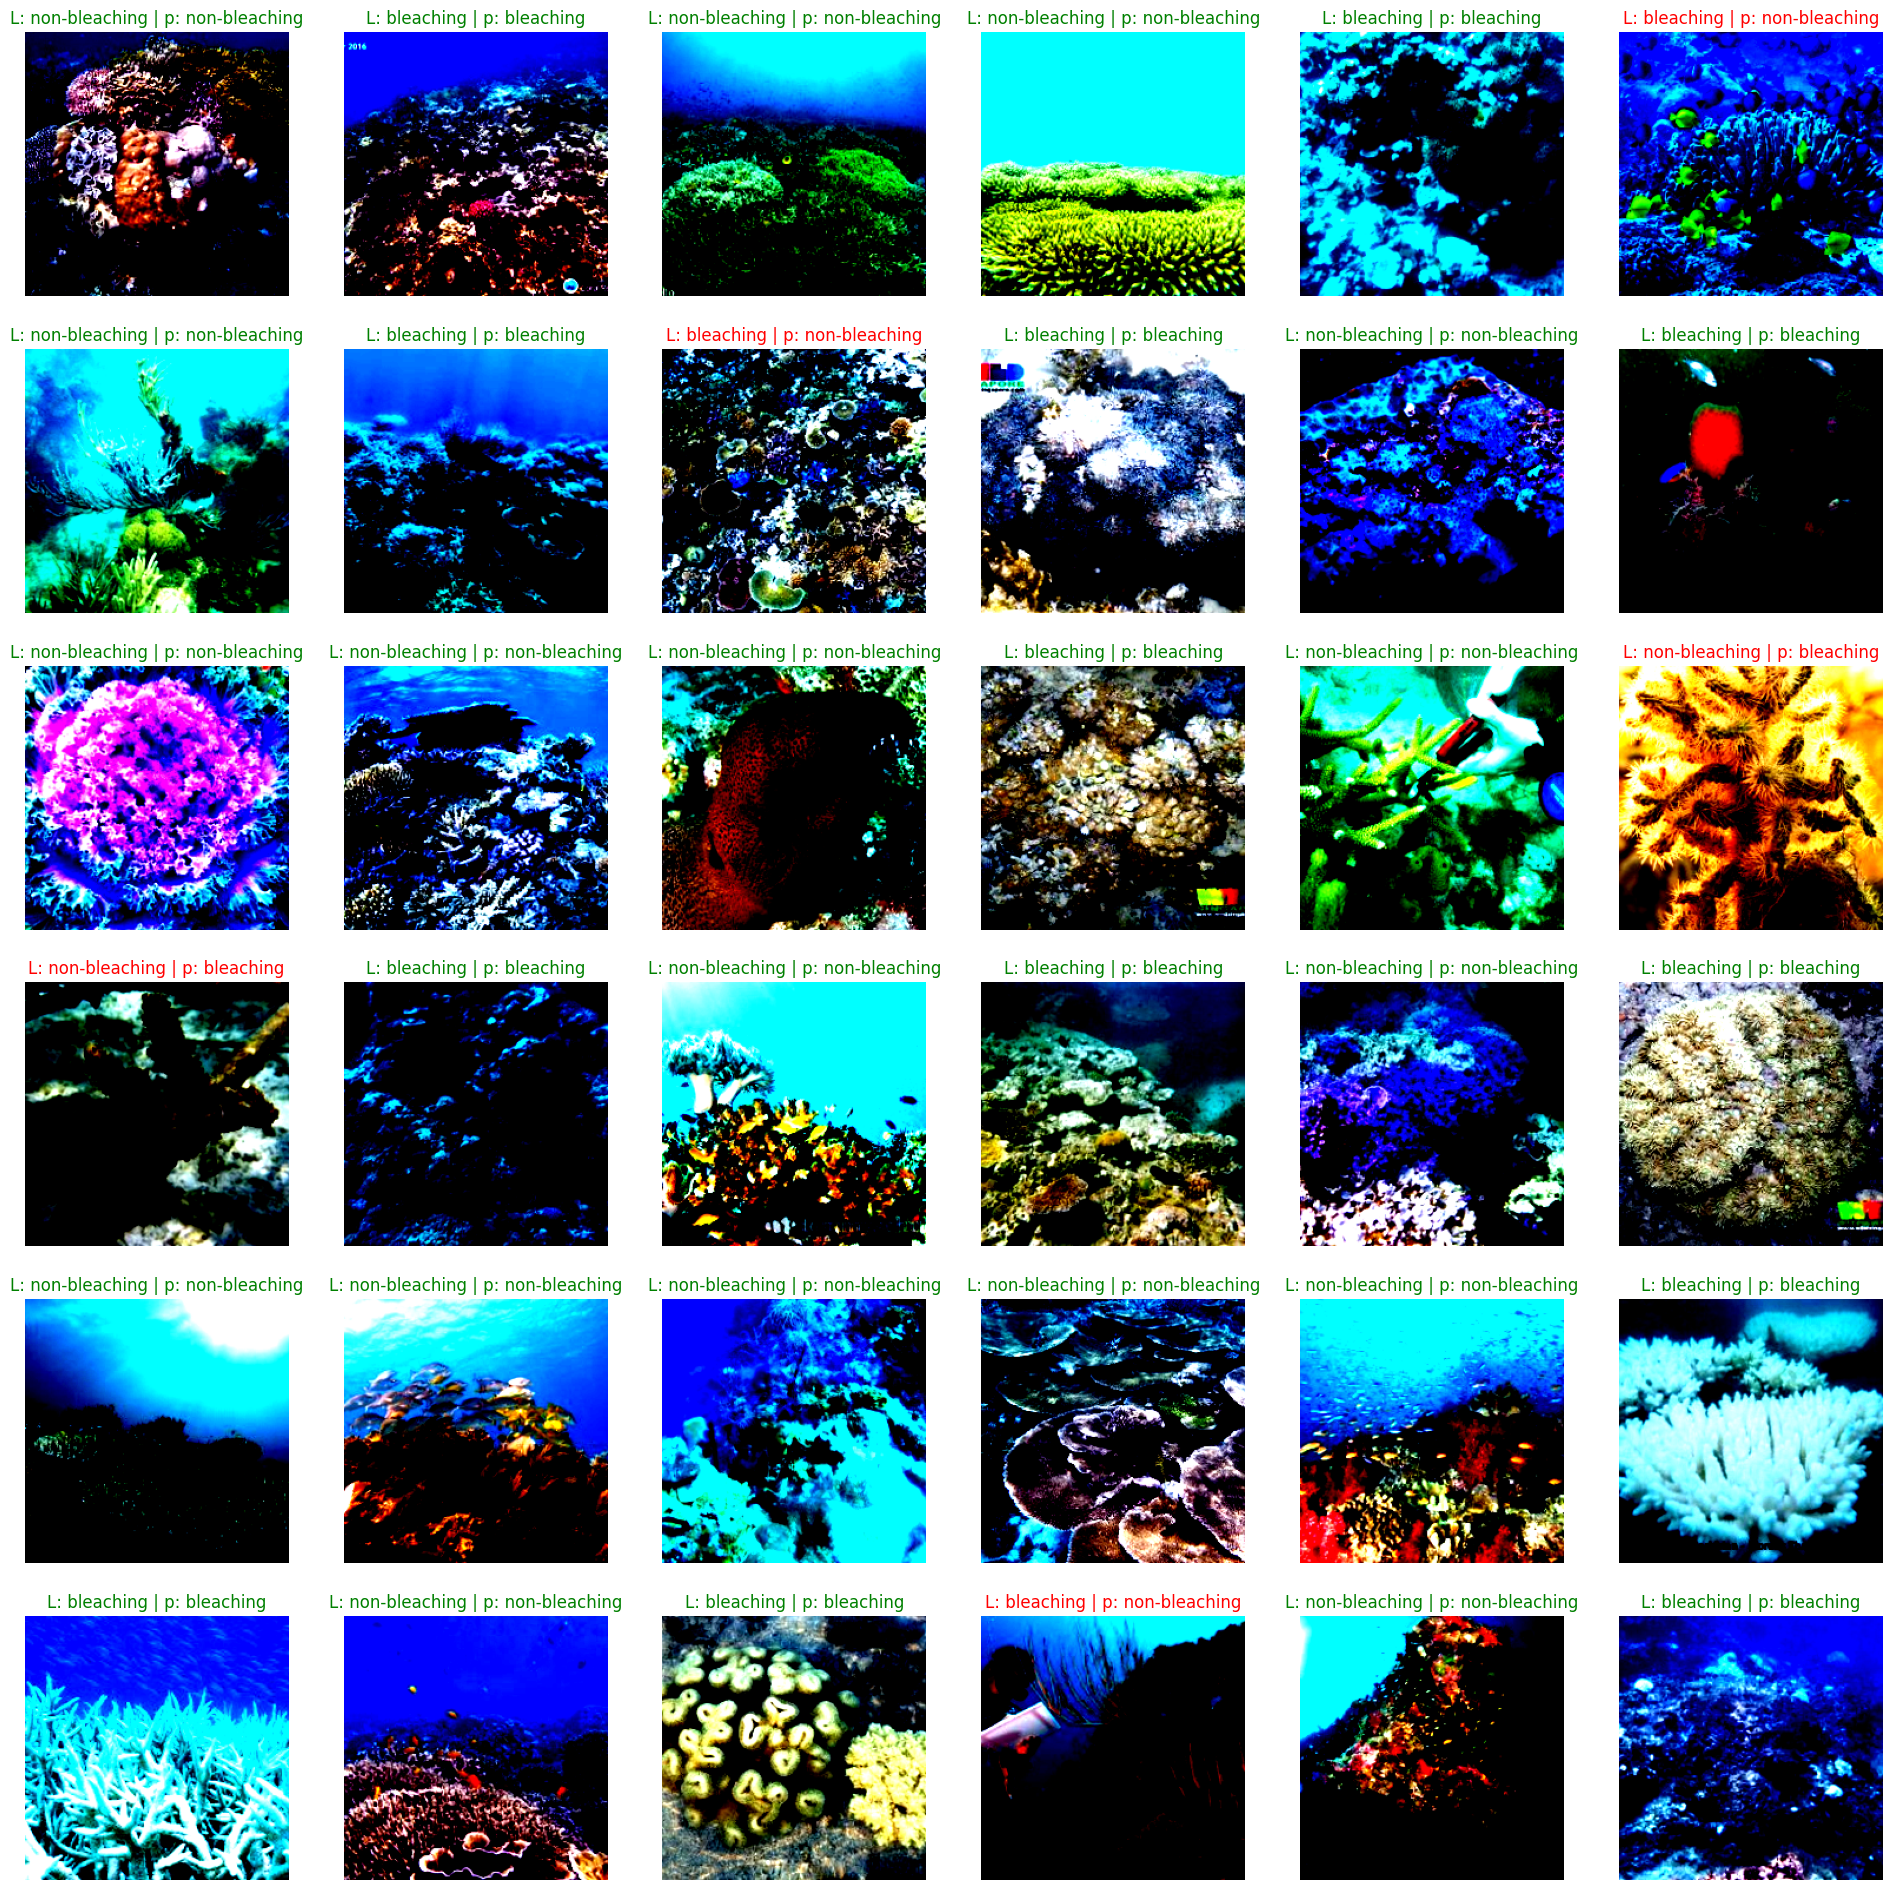

In [26]:
#plot images hasil prediksi
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred =label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | p: {pred}", fontdict=font);
    ax.axis('off');

In [27]:
from torchvision import transforms
from PIL import Image

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function untuk upload gambar
def process_uploaded_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = test_transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image




In [28]:
def test_single_image(model, image_path, label2cat, device):
    model.eval()

    # Process uploaded image
    uploaded_image = process_uploaded_image(image_path)
    uploaded_image = uploaded_image.to(device, dtype=torch.float16)  # Ensure input is in FP16

    # Convert model to mixed precision
    model = model.to(dtype=torch.float16)

    # Perform inference
    with torch.no_grad():
        output = model(uploaded_image)
        pred = output.argmax(1).item()

    # Display prediction
    predicted_label = label2cat[pred]
    print(f"Predicted Label: {predicted_label}")



In [29]:
# Menghitung persentase akurasi
final_val_accuracy = test_score * 100

# Menampilkan akurasi
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")


Final Validation Accuracy: 96.42%


In [ ]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/archive/uas_DL.pth')